In [2]:
# Todos:
# - create an 500m grid all over vienna [x]
# - generate Vectors for all of them
# - make a comparison with tu Vienna polygon

In [1]:
from create_semantic_vector import Spatial_Semantic_Vector
from shapely.geometry import Polygon, MultiPoint
import pandas as pd
import geopandas as gpd
from datetime import datetime
import numpy as np
from scipy import spatial

In [2]:
spatial_semantic_vector_obj = Spatial_Semantic_Vector('../data/spatial_semantics/kv_df_just_eng.pickle',
                                                      '../data/spatial_semantics/tag_sizes_median_df.pickle',
                                                      "../data/en_wikipedia_corpus/doc2vec_eng.pickel")
# tu wien Polygon (for testing purpose)
q_poly = Polygon([(16.36896371841431,48.20063653233946),
                  (16.373598575592045,48.19960677385028),
                  (16.371034383773807,48.19771882952509),
                  (16.36772990226746,48.19816221664037)])

In [5]:
level_1_admin = gpd.read_file("../data/shapes/level_1_admin/ne_10m_admin_1_states_provinces.shp")
# in this case we select vienna as the polyon
vienna_shape  = level_1_admin[level_1_admin['name']=='Wien']['geometry'].iloc[0]

In [6]:
min_lon, min_lat, max_lon, max_lat = vienna_shape.bounds

# 0.001° = 111 m
grid_size = 0.0005


i_lon = min_lon
i_lat = min_lat
grid_list = []
while i_lon <= max_lon:
    while i_lat <= max_lat:
        poly = Polygon([(i_lon,i_lat),(i_lon,i_lat+grid_size),(i_lon+grid_size,i_lat+grid_size),(i_lon+grid_size,i_lat)])
        if vienna_shape.contains(poly):
            grid_list.append(poly)
        
        i_lat += grid_size
    i_lat = min_lat
    i_lon += grid_size
    

<AxesSubplot:>

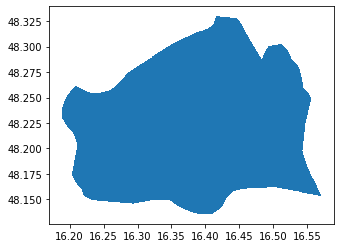

In [7]:
vienna_grid_gdf = gpd.GeoDataFrame({'geometry': grid_list}, crs="EPSG:4326")
vienna_grid_gdf.plot()

In [3]:
grid_save_path = '../data/spatial_semantics/vienna_grid_high_res_gdf.pickle'

In [8]:
#Initial setup of grid with vectors
grid_save_path = '../data/spatial_semantics/vienna_grid_high_res_gdf.pickle'
vienna_grid_vec_gdf = vienna_grid_gdf.copy()
vienna_grid_vec_gdf['spatial_semantic_vector'] = None
vienna_grid_vec_gdf.to_pickle(grid_save_path)
vienna_grid_vec_gdf

,geometry,spatial_semantic_vector
0,"POLYGON ((16.18874 48.22975, 16.18874 48.23025...",None
1,"POLYGON ((16.18874 48.23025, 16.18874 48.23075...",None
2,"POLYGON ((16.18874 48.23075, 16.18874 48.23125...",None
3,"POLYGON ((16.18874 48.23125, 16.18874 48.23175...",None
4,"POLYGON ((16.18874 48.23175, 16.18874 48.23225...",None
...,...,...
197187,"POLYGON ((16.56924 48.15375, 16.56924 48.15425...",None
197188,"POLYGON ((16.56924 48.15425, 16.56924 48.15475...",None
197189,"POLYGON ((16.56924 48.15475, 16.56924 48.15525...",None
197190,"POLYGON ((16.56974 48.15375, 16.56974 48.15425...",None


In [ ]:
vienna_grid_vec_gdf = pd.read_pickle(grid_save_path)
vienna_grid_vec_gdf = gpd.GeoDataFrame(vienna_grid_vec_gdf, geometry=vienna_grid_vec_gdf['geometry'])

for row in vienna_grid_vec_gdf[vienna_grid_vec_gdf['spatial_semantic_vector'].isnull()].iterrows():
    vienna_grid_vec_gdf.at[row[0],'spatial_semantic_vector'] = \
            spatial_semantic_vector_obj.generate_vec(row[1]['geometry'])
    vienna_grid_vec_gdf.to_pickle(grid_save_path)
    remaining = len(vienna_grid_vec_gdf[vienna_grid_vec_gdf['spatial_semantic_vector'].isnull()])
    print(f"{remaining} cells are remaining {datetime.now().time().strftime('%H:%M:%S')}")
        
vienna_grid_vec_gdf

In [ ]:
## VISUALS AFTER HERE

In [ ]:
vienna_grid_vec_gdf = pd.read_pickle(grid_save_path)
vienna_grid_vec_gdf = gpd.GeoDataFrame(vienna_grid_vec_gdf, geometry=vienna_grid_vec_gdf['geometry'])
vienna_grid_vec_test_gdf = vienna_grid_vec_gdf.reset_index().rename(columns={'index':'id'}).copy()
gdf_centroid = list(MultiPoint(vienna_grid_vec_gdf['geometry'].centroid.tolist()).centroid.coords)[0]

In [113]:
import ipyleaflet
from ipyleaflet import Map, basemaps, basemap_to_tiles, GeoJSON, WKTLayer, GeoData
from ipywidgets import Label
from branca.colormap import linear
import json


target_string = input().lower().split(' ')
taget_vector = spatial_semantic_vector_obj.doc2vec_model.infer_vector(target_string)

def cosine_similarity(cell_vector):
    r_value = None
    try:
        # this fails if cell vector isnt a cell vector but for example
        # none or the string 'no tags found'
        r_value = 1 - spatial.distance.cosine(taget_vector, cell_vector)
    except:
        pass

    return r_value

vienna_grid_vec_test_gdf['value'] = vienna_grid_vec_test_gdf['spatial_semantic_vector'].apply(cosine_similarity)
v_max = vienna_grid_vec_test_gdf['value'].max()
v_min = vienna_grid_vec_test_gdf['value'].min()
vienna_grid_vec_test_gdf = vienna_grid_vec_test_gdf.replace({np.nan: 0})


value_ramp = dict(zip(vienna_grid_vec_test_gdf['id'].tolist(),vienna_grid_vec_test_gdf['value'].tolist()))
vienna_grid_vec_test_gdf[['id','geometry']].to_file('../data/spatial_semantics/vienna_grid_vec_gdf_TMP.geojson', driver='GeoJSON')
with open('../data/spatial_semantics/vienna_grid_vec_gdf_TMP.geojson') as f:
    geo_json = json.load(f)
    
for feature in geo_json['features']:
    feature['id'] = feature['properties']['id']

m = Map(
    basemap=basemaps.CartoDB.Positron,
    center=(gdf_centroid[1],gdf_centroid[0]),
    zoom=11
)

#countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ramp_layer = ipyleaflet.Choropleth(geo_data=geo_json,
                                   choro_data=value_ramp,
                                   colormap=linear.YlOrRd_04,
                                   key_on='id',
                                   border_color='black',
                                   style={'fillOpacity': 0.8, 'opacity': 0.0, 'dashArray': '5, 5'},
                                   value_max = 0.5,
                                   value_min = 0.3)

                                   
# geo_data = GeoData(geo_dataframe = vienna_grid_vec_gdf[['id','geometry']],
#                    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
#                    name = 'Countries')

# wlayer2 = WKTLayer(
#     #wkt_string=Polygon([(cord[1],cord[0]) for cord in q_poly.exterior.coords]).wkt,
#     wkt_string=Polygon(q_poly.exterior.coords).wkt,
#     #hover_style={"fillColor": "red"},
#     fill_color="blue",
#     color="blue",

# )
print(v_max)
print(v_min)
m.add_layer(ramp_layer)
m

 art and culture


0.6111328601837158
0.1796191930770874


Map(center=[48.22334973399689, 16.38403957794017], controls=(ZoomControl(options=['position', 'zoom_in_text', …